In [1]:
import os
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
# from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import models as M
import trainer as T

from torch.utils.tensorboard import SummaryWriter

from plot_lib import set_default


In [2]:
set_default()

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [4]:
DATADIR = "/Users/mghifary/Work/Code/AI/data"
MODEL_DIR = "models"
MODEL_SUFFIX = "tinyresnet-exp1"
BATCH_SIZE = 64
EPOCHS = 25

In [5]:
# set tensorboard "log_dir" to "logs"
writer = SummaryWriter(f"logs/fashion-mnist_{MODEL_SUFFIX}")

In [6]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,)),
    ]
)

# Download training data from open datasets.
train_data = datasets.FashionMNIST(
    root=DATADIR,
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.FashionMNIST(
    root=DATADIR,
    train=False,
    download=True,
    transform=transform,
)

In [7]:
# Create data loaders
train_dataloader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_dataloader = DataLoader(
    test_data, 
    batch_size=BATCH_SIZE,
    shuffle=False,
)

for X, y in train_dataloader:
    [_, c, dx1, dx2] = X.shape
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}, {y.dtype}")
    break

num_classes = len(torch.unique(train_data.train_labels))

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]), torch.int64


/opt/homebrew/lib/python3.11/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


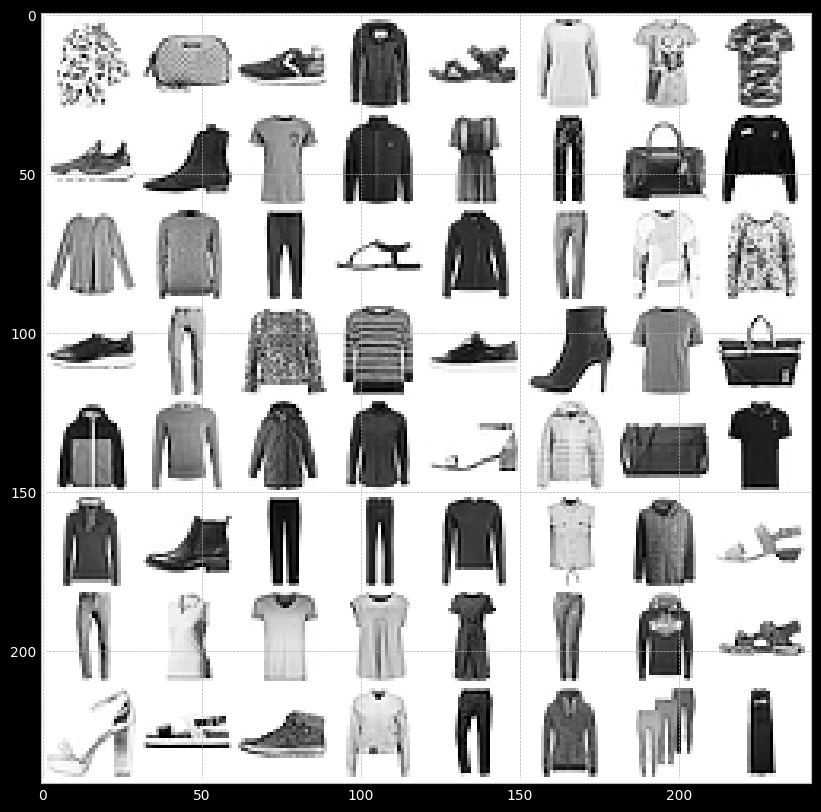

In [8]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

        
# show images
matplotlib_imshow(img_grid, one_channel=True)

In [9]:
# write to tensorboard
writer.add_image("fashion_mnist_images", img_grid)

In [10]:
# Initialize model
# model = M.NeuralNetwork(c, dx1, dx2, num_classes)
# model = M.ResNet(1, 18, M.ResidualBlock, num_classes=num_classes)
model = M.TinyResnet(c, M.ResidualBlock, num_classes=num_classes)
model = model.to(device)
print(model)

TinyResnet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    

In [11]:
# Optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [12]:
# Inspect model using Tensorboard
writer.add_graph(model, images)

In [13]:
checkpoint_dir = os.path.join(MODEL_DIR, "fashion-mnist")

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_path = os.path.join(checkpoint_dir, f"{MODEL_SUFFIX}.pth")

T.fit(
    model, 
    train_dataloader, 
    test_dataloader, 
    loss_fn, 
    optimizer, 
    n_epochs=EPOCHS, 
    checkpoint_path=checkpoint_path, 
    writer=writer
)
 
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 938/938 [01:02<00:00, 15.01batch/s, loss=0.667]


Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp1.pth
Test Performance: 
 Accuracy: 83.40%, Avg loss: 0.4625 

Test Performance: 
 Accuracy: 82.33%, Avg loss: 0.4945 

Elapsed time: 62.47 seconds

Epoch 2
-------------------------------


100%|██████████| 938/938 [00:58<00:00, 16.04batch/s, loss=0.288]


Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp1.pth
Test Performance: 
 Accuracy: 80.72%, Avg loss: 0.5226 

Test Performance: 
 Accuracy: 78.89%, Avg loss: 0.5773 

Elapsed time: 58.47 seconds

Epoch 3
-------------------------------


100%|██████████| 938/938 [00:59<00:00, 15.84batch/s, loss=0.278] 


Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp1.pth
Test Performance: 
 Accuracy: 88.99%, Avg loss: 0.2978 

Test Performance: 
 Accuracy: 87.73%, Avg loss: 0.3452 

Elapsed time: 59.21 seconds

Epoch 4
-------------------------------


100%|██████████| 938/938 [00:59<00:00, 15.70batch/s, loss=0.333] 


Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp1.pth
Test Performance: 
 Accuracy: 88.83%, Avg loss: 0.3102 

Test Performance: 
 Accuracy: 86.54%, Avg loss: 0.3706 

Elapsed time: 59.74 seconds

Epoch 5
-------------------------------


100%|██████████| 938/938 [00:58<00:00, 16.03batch/s, loss=0.324] 


Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp1.pth
Test Performance: 
 Accuracy: 89.76%, Avg loss: 0.2807 

Test Performance: 
 Accuracy: 87.90%, Avg loss: 0.3364 

Elapsed time: 58.51 seconds

Done!
